In [1]:
import pandas as pd
import numpy as np

import sys

sys.path.append('~/PycharmProjects/Boston_housing/')

df_master = pd.read_csv('./data/raw/' + 'redfin_2020-01-19-08-17-26.csv')
df_master.pop('SOLD DATE')
df_condo = pd.read_csv('./data/processed/' + 'Boston_condo_transaction.csv',index_col=0)
df_sfr = pd.read_csv('./data/processed/' + 'Boston_single_family_residential_transaction.csv',index_col=0)
df_townhouse = pd.read_csv('./data/processed/' + 'Boston_townhouse_transaction.csv',index_col=0)

df_transaction = pd.concat([df_condo,df_sfr,df_townhouse])

df = df_master.join(df_transaction,how='inner')

In [2]:
def upper_outlier(x):
    return  np.quantile(x,0.75) + 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

def lower_outlier(x):
    return  np.quantile(x,0.25) - 1.5*(np.quantile(x,0.75)-np.quantile(x,0.25))

df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['LIST DATE'] = pd.to_datetime(df['LIST DATE'])
df['DAYS ON MKT'] = (df['SOLD DATE'] - df['LIST DATE']).apply(lambda x: x.days)
df['HOA/MONTH'] = df['HOA/MONTH'].fillna(0)
df['PREMIUM'] = (df['SOLD PRICE'] - df['LIST PRICE'])/df['LIST PRICE']

df_upper_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: upper_outlier(x),axis=0)
df_lower_outlier = df[['DAYS ON MKT','SOLD PRICE','LIST PRICE','HOA/MONTH','PREMIUM']].apply(
    lambda x: lower_outlier(x),axis=0)

print('number of data before outlier removal: ',len(df))

df = df[(df['DAYS ON MKT'] < df_upper_outlier['DAYS ON MKT'])&
        (df['SOLD PRICE'] < df_upper_outlier['SOLD PRICE']) &
        (df['LIST PRICE'] < df_upper_outlier['LIST PRICE']) &
        (df['HOA/MONTH'] < df_upper_outlier['HOA/MONTH']) &
        (df['PREMIUM'] < df_upper_outlier['PREMIUM']) &
        (df['DAYS ON MKT'] > df_lower_outlier['DAYS ON MKT']) &
        (df['SOLD PRICE'] > df_lower_outlier['SOLD PRICE']) & 
        (df['LIST PRICE'] > df_lower_outlier['LIST PRICE']) &
        (df['PREMIUM'] > df_lower_outlier['PREMIUM'])]


print('number of data after outlier removal: ',len(df))

df = df[df['DAYS ON MKT'] > 0] # price history scraped after the spreadsheet
df = df[np.abs((df['SOLD PRICE']-df['LIST PRICE'])/df['LIST PRICE']) < 1] # typo in listing/selling price

print('number of data after removing new data: ',len(df))

number of data before outlier removal:  7912
number of data after outlier removal:  6048
number of data after removing new data:  6046


<IPython.core.display.Javascript object>


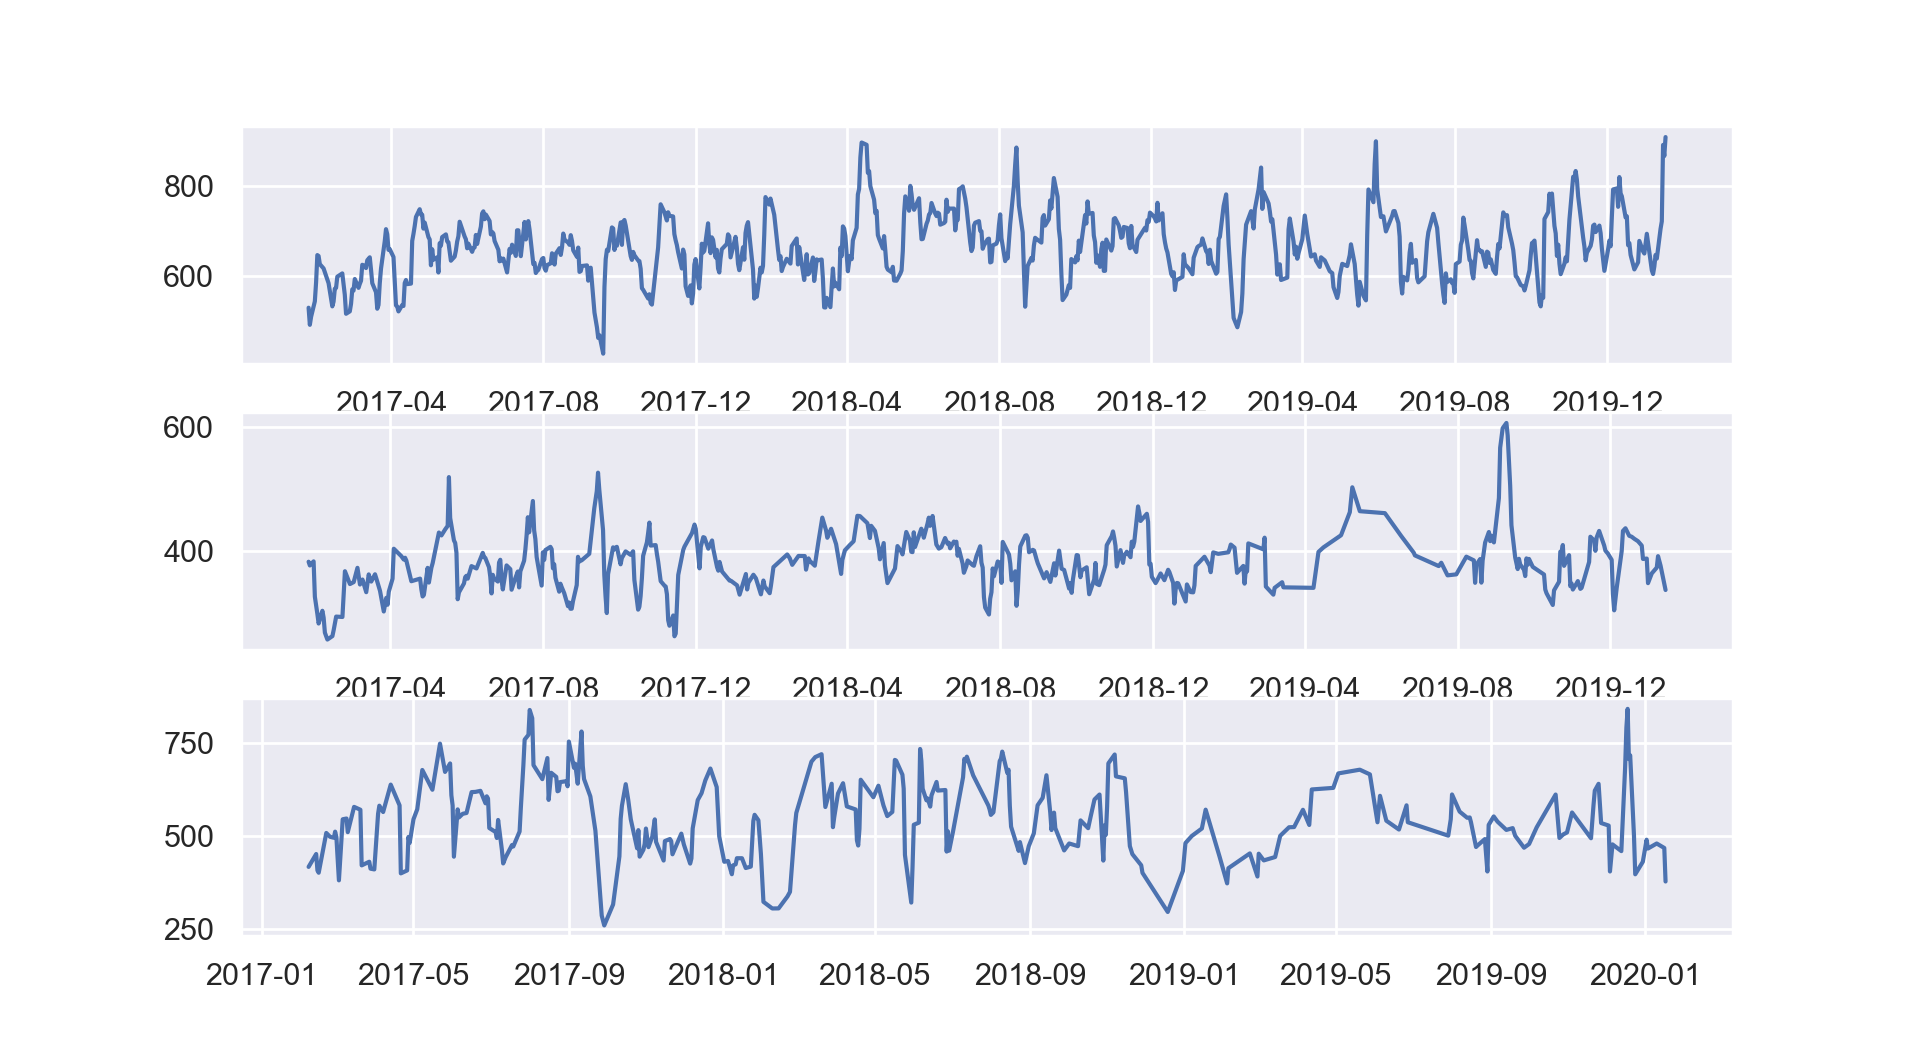

//anaconda3/envs/insight/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

import seaborn as sns

sns.set()

df = df.sort_values('SOLD DATE')

df_condo = df[df['PROPERTY TYPE'] == 'Condo/Co-op']
df_sfr = df[df['PROPERTY TYPE'] == 'Single Family Residential']
df_townhouse = df[df['PROPERTY TYPE'] == 'Townhouse']


df_condo_price_per_sqft = df_condo[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_condo_rolling_price_per_sqft = df_condo_price_per_sqft.rolling(5).mean()

df_sfr_price_per_sqft = df_sfr[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_sfr_rolling_price_per_sqft = df_sfr_price_per_sqft.rolling(5).mean()

df_townhouse_price_per_sqft = df_townhouse[['SOLD DATE','$/SQUARE FEET']].groupby('SOLD DATE').mean()
df_townhouse_rolling_price_per_sqft = df_townhouse_price_per_sqft.rolling(5).mean()

fig = plt.figure()
ax = fig.add_subplot(3,1,1)
plt.plot(df_condo_rolling_price_per_sqft.index,df_condo_rolling_price_per_sqft['$/SQUARE FEET'])

ax = fig.add_subplot(3,1,2)
plt.plot(df_sfr_rolling_price_per_sqft.index,df_sfr_rolling_price_per_sqft['$/SQUARE FEET'])

ax = fig.add_subplot(3,1,3)
plt.plot(df_townhouse_rolling_price_per_sqft.index,df_townhouse_rolling_price_per_sqft['$/SQUARE FEET'])
plt.show()

In [43]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


df_condo_rolling_price_per_sqft = df_condo_rolling_price_per_sqft.dropna()

condo_rolling_price_per_sqft = df_condo_rolling_price_per_sqft['$/SQUARE FEET'].values

scaler = MinMaxScaler(feature_range=(0,1))
condo_rolling_price_per_sqft_scaled = scaler.fit_transform(condo_rolling_price_per_sqft.reshape(-1,1))

train_size = int(len(condo_rolling_price_per_sqft_scaled) * 0.7)
test_size = len(condo_rolling_price_per_sqft_scaled) - train_size
train = condo_rolling_price_per_sqft_scaled[0:train_size,:] 
test = condo_rolling_price_per_sqft_scaled[train_size:len(condo_rolling_price_per_sqft_scaled),:]
print('ntrain: ',len(train),' ntest: ',len(test))

look_back = 10 # this will be the hidden size in LSTM
Xtrain, Ytrain = create_dataset(train, look_back)
Xtest, Ytest = create_dataset(test, look_back)

print('Xtrain.shape: ',Xtrain.shape)
print('Xtest.shape: ',Xtest.shape)

ntrain:  497  ntest:  214
Xtrain.shape:  (486, 10)
Xtest.shape:  (203, 10)


In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# reshape input to be [samples, time steps, features]
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], 1, Xtrain.shape[1]))
Xtest = np.reshape(Xtest, (Xtest.shape[0], 1, Xtest.shape[1]))


model = Sequential()
model.add(LSTM(10, input_shape=(1, look_back))) # input_shape=(number of time step, hidden size)
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, Ytrain, epochs=200, batch_size=11, verbose=2)



Epoch 1/200
 - 1s - loss: 0.1362
Epoch 2/200
 - 0s - loss: 0.0200
Epoch 3/200
 - 0s - loss: 0.0161
Epoch 4/200
 - 0s - loss: 0.0149
Epoch 5/200
 - 0s - loss: 0.0139
Epoch 6/200
 - 0s - loss: 0.0129
Epoch 7/200
 - 0s - loss: 0.0120
Epoch 8/200
 - 0s - loss: 0.0112
Epoch 9/200
 - 0s - loss: 0.0105
Epoch 10/200
 - 0s - loss: 0.0098
Epoch 11/200
 - 0s - loss: 0.0092
Epoch 12/200
 - 0s - loss: 0.0086
Epoch 13/200
 - 0s - loss: 0.0082
Epoch 14/200
 - 0s - loss: 0.0078
Epoch 15/200
 - 0s - loss: 0.0073
Epoch 16/200
 - 0s - loss: 0.0072
Epoch 17/200
 - 0s - loss: 0.0067
Epoch 18/200
 - 0s - loss: 0.0065
Epoch 19/200
 - 0s - loss: 0.0064
Epoch 20/200
 - 0s - loss: 0.0061
Epoch 21/200
 - 0s - loss: 0.0059
Epoch 22/200
 - 0s - loss: 0.0059
Epoch 23/200
 - 0s - loss: 0.0058
Epoch 24/200
 - 0s - loss: 0.0057
Epoch 25/200
 - 0s - loss: 0.0056
Epoch 26/200
 - 0s - loss: 0.0056
Epoch 27/200
 - 0s - loss: 0.0054
Epoch 28/200
 - 0s - loss: 0.0054
Epoch 29/200
 - 0s - loss: 0.0052
Epoch 30/200
 - 0s - lo

<IPython.core.display.Javascript object>


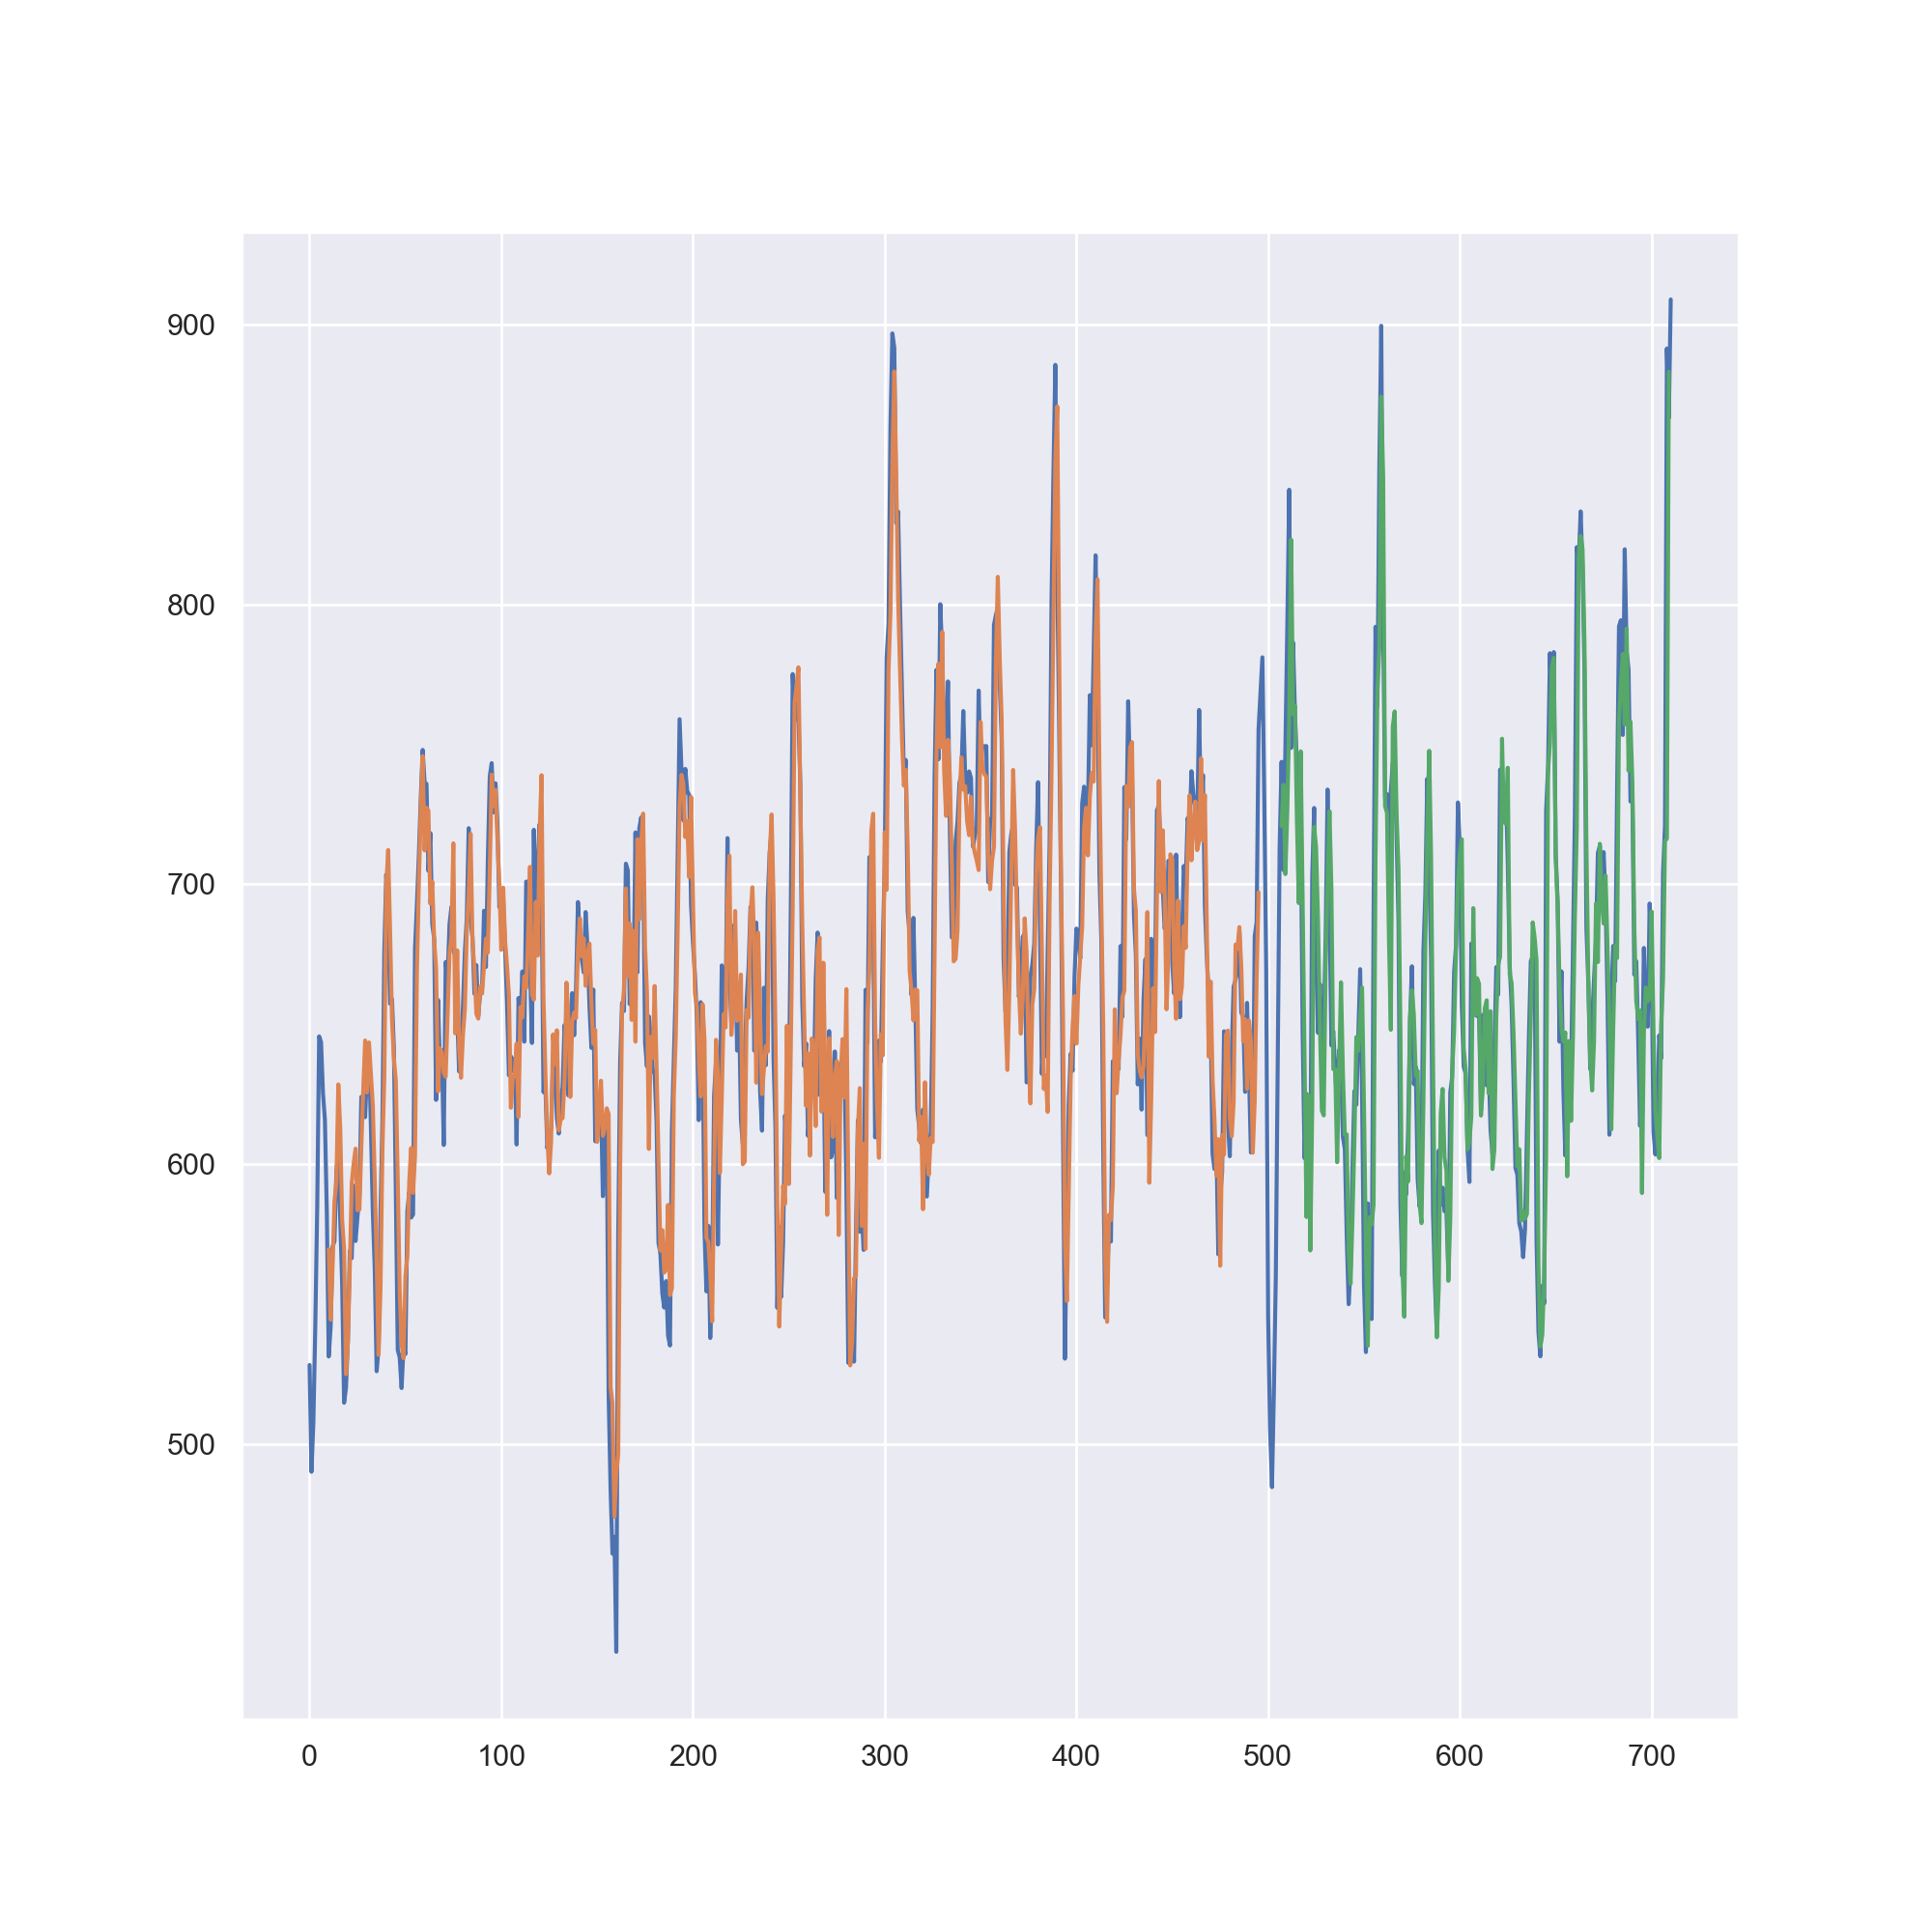

In [45]:
Ytrain_pred = model.predict(Xtrain)
Ytest_pred = model.predict(Xtest)

Ytrain = scaler.inverse_transform(Ytrain.reshape(-1,1))
Ytrain_pred = scaler.inverse_transform(Ytrain_pred)
Ytest = scaler.inverse_transform(Ytest.reshape(-1,1))
Ytest_pred = scaler.inverse_transform(Ytest_pred)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(condo_rolling_price_per_sqft_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(Ytrain_pred)+look_back, :] = Ytrain_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(condo_rolling_price_per_sqft_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(Ytrain_pred)+(look_back*2)+1:len(condo_rolling_price_per_sqft_scaled)-1, :] = Ytest_pred
# plot baseline and predictions

fig = plt.figure(figsize=(10,10))
plt.plot(scaler.inverse_transform(condo_rolling_price_per_sqft_scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [46]:
from sklearn.metrics import mean_squared_error

mse_lstm = mean_squared_error(Ytest[1:],Ytest_pred[1:])
mse_baseline = mean_squared_error(Ytest[1:],Ytest[:-1])
lift = -(np.sqrt(mse_lstm)-np.sqrt(mse_baseline))/np.sqrt(mse_baseline)


print('MSE: ',mse_lstm)
print('MSE (baseline): ',mse_baseline)
print('lift: %.2f%%'%(lift*100))

MSE:  1276.9244882342934
MSE (baseline):  1873.9723597979
lift: 17.45%
